In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory
train_data=image_dataset_from_directory('/kaggle/input/lego-brick-images/dataset',labels=None,color_mode='grayscale',image_size=(64,64),seed=3,shuffle=True,interpolation='bilinear')

Found 40000 files belonging to 1 classes.


In [5]:
from tensorflow import cast
def preprocessing(img):
    img = (cast(img,'float32')-127.5)/127.5
    return img
#By using this instead of /255 we get values between -1 and 1 rather than 0 and 1.

In [6]:
train_data = train_data.map(lambda x: preprocessing(x))

In [7]:
from tensorflow.keras.layers import Conv2D,LeakyReLU,Dropout,BatchNormalization,Dense,Flatten,Reshape,Conv2DTranspose,LeakyReLU,Input, UpSampling2D, GlobalAveragePooling2D, Conv2DTranspose
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation

Batch normalization normalizes the activations of each batch across the channel dimension and improves the training process and the overall performance of the model. It is typically applied after the convolutional or fully connected layers.

The LeakyReLU function introduces a small slope to the negative part of the input, allowing for the propagation of small negative values rather than fully zeroing them out. This helps to address the "dying ReLU" problem, where ReLU units can become stuck in a state where they output zero for all inputs, leading to a complete halt in learning.

GlobalAveragePooling2D is a pooling operation used in deep learning models to reduce the spatial dimensions of the input and provide a global summary of the features. It is typically applied after the convolutional layers in a model and helps in dimensionality reduction.

In [10]:
def make_discriminator():
    model=Sequential()
    model.add(Conv2D(16,input_shape=(64,64,1),kernel_size=4,padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(Conv2D(16,kernel_size=4,strides=2,padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.3))
    #block 2          
    model.add(Conv2D(32,kernel_size=4,padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=4,strides=2,padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.3))
    #block 3
    model.add(Conv2D(64,kernel_size=4,padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=4,strides=2,padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.3))
    #block 4
    model.add(Conv2D(128,kernel_size=4,padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(Conv2D(128,kernel_size=4,strides=2,padding='same',use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.3))
    #result       
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))    
    #Note : We can use variables instead of entering numbers directly to manipulate and check on different values
    
    return model

In [11]:
latent_dim=100
channels=1
def make_generator():
    model = Sequential()
    model.add(Input(latent_dim,))
    model.add(Dense(4 * 4 * (16* 8)))
    model.add(Reshape((4,4,16*8)))
    #block 1
    model.add(Conv2DTranspose(64,4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.3))
    #block 2
    model.add(Conv2DTranspose(32,4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.3))
    #block 3
    model.add(Conv2DTranspose(16,4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.3))
    #block 4
    model.add(Conv2DTranspose(16,4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.3))
    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=5,padding="same"))
    model.add(Activation("tanh"))

    return model

In [12]:
# Create an instance of the discriminator
discriminator = make_discriminator()
generator = make_generator()

In [13]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        256       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4096      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        8

In [14]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         131136    
 nspose)                                                         
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 32)      

In [15]:
def generate_noise(batch_size, noise_dim):
    noise = np.random.normal(0, 1, (batch_size, 64, 64, 1))
    return noise


# Example usage
batch_size = 32
noise_dim = 100 #latent space  
noise = generate_noise(batch_size, noise_dim)
SEED_SIZE=100

In [16]:
from tensorflow import keras
import tensorflow as tf

In [22]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = make_discriminator()
        self.generator = make_generator()
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [23]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
            plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
            plt.show()

In [25]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.losses import BinaryCrossentropy
epochs = 40  #epcohs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00012),
    loss_fn=BinaryCrossentropy(),
)
gan.fit(
    train_data, epochs=epochs,  callbacks=[GANMonitor(num_img=10, latent_dim=100)]
)



Epoch 1/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.2339 - g_loss: 5.2513

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 173s 67ms/step - d_loss: 0.2339 - g_loss: 5.2513
Epoch 2/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.6031 - g_loss: 1.0705

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.6031 - g_loss: 1.0705
Epoch 3/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5860 - g_loss: 1.1913

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 66ms/step - d_loss: 0.5860 - g_loss: 1.1913
Epoch 4/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5604 - g_loss: 1.2949

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 81s 64ms/step - d_loss: 0.5604 - g_loss: 1.2949
Epoch 5/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.6076 - g_loss: 1.1512

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 80s 64ms/step - d_loss: 0.6076 - g_loss: 1.1512
Epoch 6/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5459 - g_loss: 1.3351

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 82s 66ms/step - d_loss: 0.5459 - g_loss: 1.3351
Epoch 7/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5413 - g_loss: 1.4195

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 85s 68ms/step - d_loss: 0.5413 - g_loss: 1.4195
Epoch 8/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5218 - g_loss: 1.5176

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 67ms/step - d_loss: 0.5218 - g_loss: 1.5176
Epoch 9/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5216 - g_loss: 1.4540

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 86s 68ms/step - d_loss: 0.5216 - g_loss: 1.4540
Epoch 10/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5788 - g_loss: 1.1859

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 67ms/step - d_loss: 0.5788 - g_loss: 1.1859
Epoch 11/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5588 - g_loss: 1.3479

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 86s 69ms/step - d_loss: 0.5588 - g_loss: 1.3479
Epoch 12/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5628 - g_loss: 1.2517

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 85s 67ms/step - d_loss: 0.5628 - g_loss: 1.2517
Epoch 13/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5387 - g_loss: 1.4054

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 67ms/step - d_loss: 0.5387 - g_loss: 1.4054
Epoch 14/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5249 - g_loss: 1.4839

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 85s 67ms/step - d_loss: 0.5249 - g_loss: 1.4839
Epoch 15/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5551 - g_loss: 1.3171

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 67ms/step - d_loss: 0.5551 - g_loss: 1.3171
Epoch 16/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5511 - g_loss: 1.3142

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.5511 - g_loss: 1.3142
Epoch 17/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5226 - g_loss: 1.4058

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.5226 - g_loss: 1.4058
Epoch 18/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5326 - g_loss: 1.4051

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 82s 66ms/step - d_loss: 0.5326 - g_loss: 1.4051
Epoch 19/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5372 - g_loss: 1.3823

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.5372 - g_loss: 1.3823
Epoch 20/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.5199 - g_loss: 1.5261

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 85s 68ms/step - d_loss: 0.5199 - g_loss: 1.5261
Epoch 21/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.4951 - g_loss: 1.6629

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 85s 68ms/step - d_loss: 0.4951 - g_loss: 1.6629
Epoch 22/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.4676 - g_loss: 1.7890

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.4676 - g_loss: 1.7890
Epoch 23/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.4465 - g_loss: 1.9232

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 86s 69ms/step - d_loss: 0.4465 - g_loss: 1.9232
Epoch 24/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.4246 - g_loss: 2.0560

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 67ms/step - d_loss: 0.4246 - g_loss: 2.0560
Epoch 25/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3917 - g_loss: 2.2783

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 67ms/step - d_loss: 0.3917 - g_loss: 2.2783
Epoch 26/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3766 - g_loss: 2.4332

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 67ms/step - d_loss: 0.3766 - g_loss: 2.4332
Epoch 27/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3673 - g_loss: 2.4189

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 84s 67ms/step - d_loss: 0.3673 - g_loss: 2.4189
Epoch 28/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3611 - g_loss: 2.4232

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 85s 67ms/step - d_loss: 0.3611 - g_loss: 2.4232
Epoch 29/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3749 - g_loss: 2.4277

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 85s 68ms/step - d_loss: 0.3749 - g_loss: 2.4277
Epoch 30/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3616 - g_loss: 2.4669

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 85s 67ms/step - d_loss: 0.3616 - g_loss: 2.4669
Epoch 31/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3620 - g_loss: 2.4186

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.3620 - g_loss: 2.4186
Epoch 32/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3545 - g_loss: 2.5038

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 82s 65ms/step - d_loss: 0.3545 - g_loss: 2.5038
Epoch 33/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3491 - g_loss: 2.5748

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.3491 - g_loss: 2.5748
Epoch 34/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3455 - g_loss: 2.5085

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.3455 - g_loss: 2.5085
Epoch 35/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3484 - g_loss: 2.4809

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 83s 66ms/step - d_loss: 0.3484 - g_loss: 2.4809
Epoch 36/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3448 - g_loss: 2.5326

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 82s 65ms/step - d_loss: 0.3448 - g_loss: 2.5326
Epoch 37/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3290 - g_loss: 2.6581

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 82s 66ms/step - d_loss: 0.3290 - g_loss: 2.6581
Epoch 38/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3251 - g_loss: 2.6774

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 92s 73ms/step - d_loss: 0.3251 - g_loss: 2.6774
Epoch 39/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3260 - g_loss: 2.6313

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 92s 73ms/step - d_loss: 0.3260 - g_loss: 2.6313
Epoch 40/40
1250/1250 [==============================] - ETA: 0s - d_loss: 0.3287 - g_loss: 2.6151

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

1250/1250 [==============================] - 94s 75ms/step - d_loss: 0.3287 - g_loss: 2.6151


In [43]:
num_images=5 
latent_dim=100
latent_vectors = np.random.normal(size=(num_images, latent_dim))

# Generate images
generated_images = gan.generator.predict(latent_vectors)

1/1 [==============================] - 0s 21ms/step


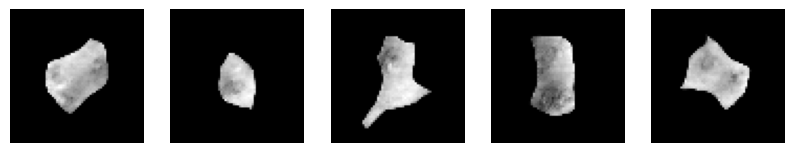

In [44]:
generated_images = (generated_images + 1) * 127.5

#to uint8 data type
generated_images = generated_images.astype(np.uint8)

#to grayscale
generated_images_gray = np.mean(generated_images, axis=-1)

# Create a grid of grayscale images
fig, axs = plt.subplots(1, num_images, figsize=(10, 10))
for i in range(num_images):
    image_gray = generated_images_gray[i]
    axs[i].imshow(image_gray, cmap='gray')
    axs[i].axis('off')


plt.show()

We observe the images generate quite middleish. The reason is probably less number of epochs as well as the quick loss decrease in the discriminator.
I will try to fix this in my next Generative model.